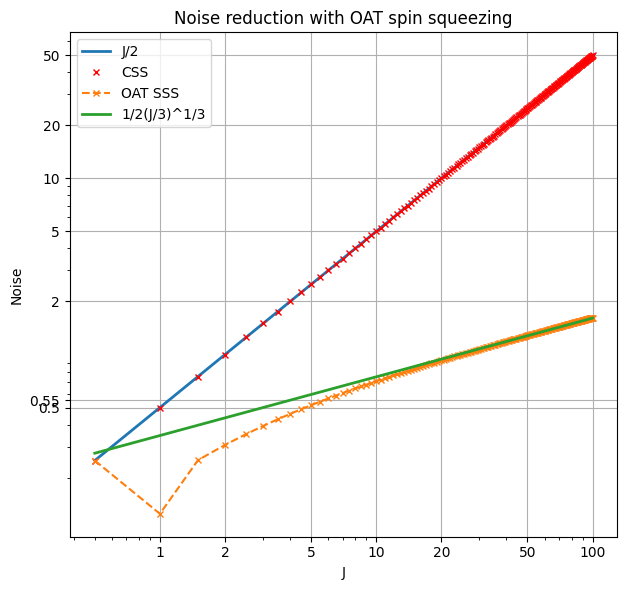

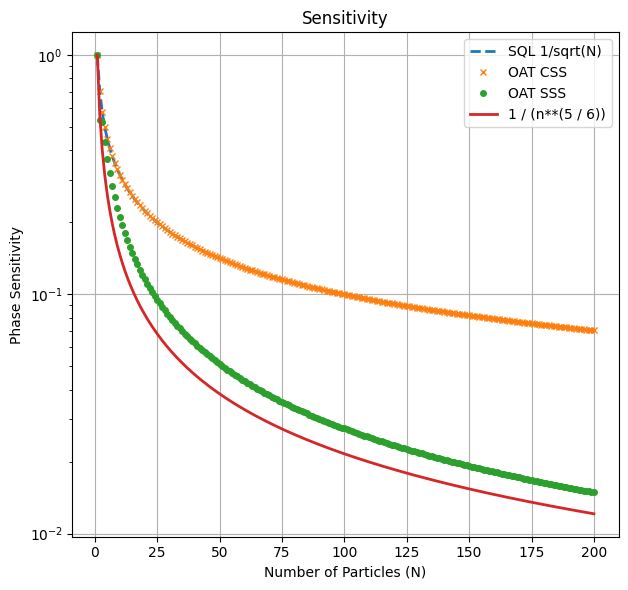

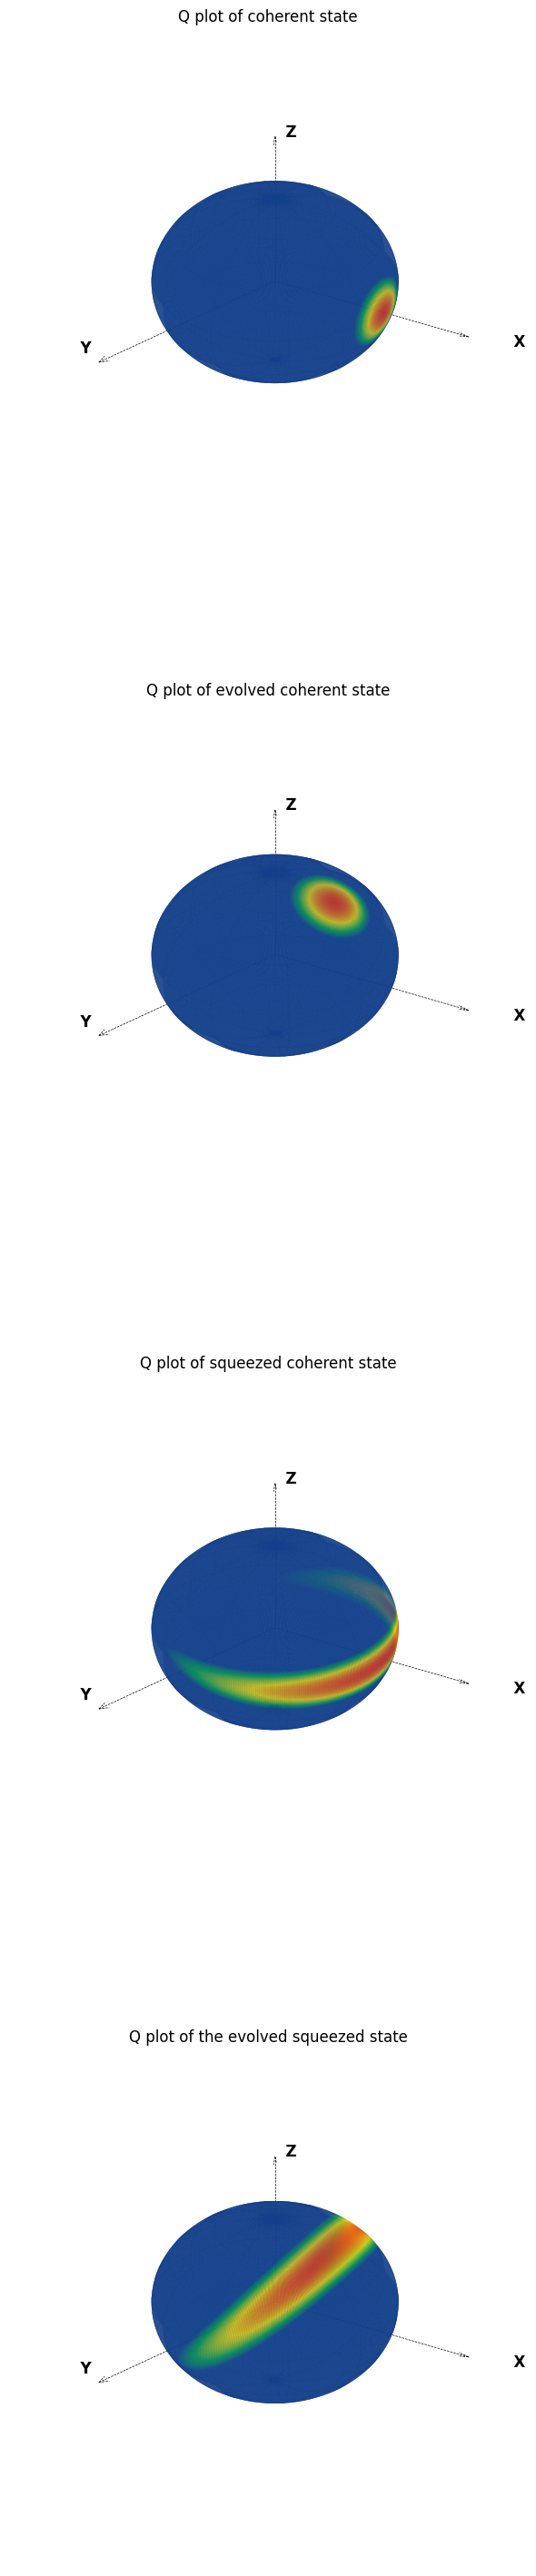

In [1]:
from quantum_metrology.config import N_MAX
from quantum_metrology.utils.husimi import plot_husimi_all_states
from quantum_metrology.utils.metrology import calculate_phase_noise
from quantum_metrology.utils.plotting import plot_noise_reduction, plot_sensitivity


def main():
    experiments = calculate_phase_noise(N_MAX)
    plot_noise_reduction(N_MAX, experiments)
    plot_sensitivity(N_MAX, experiments)
    plot_husimi_all_states(N_MAX/2, experiments)


if __name__ == "__main__":
    main()